In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)


# file paths
PATH = "/content/drive/My Drive/"
file_path = "/content/drive/My Drive/Mcovers2.zip"
csv_path = "Dataset.csv"
cover_path = "/content/Mcovers2/"

# constants
val_ratio = 0.1
test_ratio = 0.2
BUFFER_SIZE = 1000
BATCH_SIZE = 32
steps_train = (50000*0.7) // BATCH_SIZE
steps_val = (50000*0.1) // BATCH_SIZE
steps_test = (50000*0.2) // BATCH_SIZE
IMG_DIM = (224, 224, 3)
outdim_size = 15
vocab_size = 24814

# tfrecord file name for train, test and val
tfrecord_path = ["train_data.tfrecord", "val_data.tfrecord", "test_data.tfrecord"]

# unzip files
def unzip_data(file_path):
  from zipfile import ZipFile
  with ZipFile(file_path, "r") as zip:
    zip.extractall()
    return "Data has been extracted"

unzip_data(file_path)

2.3.0


'Data has been extracted'

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

def load_csv():
    """ load the data from csv file and split those into train, validation and test parts """
    df = pd.read_csv(csv_path, header = 0, index_col = 0, encoding='latin1')
    # split the data into train, validation and test
    train_data, val_data = train_test_split(df, test_size=(test_ratio+val_ratio), random_state=21)
    val_data, test_data = train_test_split(val_data, test_size=test_ratio/(test_ratio+val_ratio), random_state=21)
    return train_data, val_data, test_data


def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def make_example(image_string, label):
    feature = {
        'image_string': _bytes_feature(image_string),
        'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def write_tfrecord(data, tfrecord_path):
    with tf.io.TFRecordWriter(tfrecord_path) as writer:
        for _,row in data.iterrows():
            img_file = cover_path+str(row["id"])+'.jpg'
            label = row["cat_id"]
            image_string = open(img_file, 'rb').read()
            example = make_example(image_string, label)  
            writer.write(example.SerializeToString())   


# healper functions for reading tfrecord data 
feature_description = {
    'image_string': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64),
}

def parser(proto):
    parsed_features = tf.io.parse_single_example(proto, feature_description)
    image = parsed_features['image_string']
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_DIM[0], IMG_DIM[1]])
    label = parsed_features['label']
    return image, label

def get_dataset(tfrecord_path):
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset = dataset.map(parser, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    #dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

def load_data(first_time=True):
    if first_time:
        data = load_csv()
        for i in range(3):
           write_tfrecord(data[i], tfrecord_path[i])

    # load the dataset    
    dataset = []   
    for i in range(3):
        data = get_dataset(tfrecord_path[i])
        dataset.append(data)
    return dataset

In [ ]:
train_data, val_data, test_data = load_data(True)

In [ ]:
import matplotlib.pyplot as plt

def train_model(model, epoch_num, verbose=1):

    earlystop = callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=1)
    checkpointer = callbacks.ModelCheckpoint(filepath="temp_weights.h5", verbose=1, save_best_only=True, save_weights_only=True)
  
    history = model.fit(train_data.repeat(),
                        steps_per_epoch = steps_train,
                        epochs = epoch_num,
                        validation_data= val_data.repeat(),
                        validation_steps = steps_val,
                        use_multiprocessing=True,
                        verbose=verbose,
                        callbacks=[checkpointer, earlystop])


    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


    model.load_weights("temp_weights.h5")
    results = model.evaluate(val_data, use_multiprocessing=True, verbose=1)
    results = dict(zip(model.metrics_names, results))
    print('Result on validation data: ', results)

    results = model.evaluate(test_data, use_multiprocessing=True, verbose=1)
    results = dict(zip(model.metrics_names, results))
    print('Result on test data: ', results)



    return model

In [ ]:
import tensorflow_hub as hub
from tensorflow.keras import layers, applications, models, optimizers, losses, regularizers, callbacks, metrics

def get_model_name(base_model):
    model_name = base_model.split("/")
    return model_name[5].capitalize()

def create_model_hub(base_model, lr=0.001):         
    model = tf.keras.Sequential([
        hub.KerasLayer(base_model, trainable=False),
        #layers.Dense(1024, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(outdim_size, activation='softmax')
    ])
    model.build([None, IMG_DIM[0], IMG_DIM[1], IMG_DIM[2]])  # Batch input shape.

    optimizer = optimizers.Adam(learning_rate=lr)
    loss=losses.sparse_categorical_crossentropy
    #metric = ['accuracy', metrics.SparseTopKCategoricalAccuracy(3)]
    metric = ['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(3)]
    model.compile(optimizer, loss, metric)

    return model

In [ ]:
model = create_model_hub("https://tfhub.dev/google/imagenet/mobilenet_v1_075_224/feature_vector/4", 0.0001)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 768)               1832976   
_________________________________________________________________
dense (Dense)                (None, 2048)              1574912   
_________________________________________________________________
dense_1 (Dense)              (None, 15)                30735     
Total params: 3,438,623
Trainable params: 1,605,647
Non-trainable params: 1,832,976
_________________________________________________________________


Epoch 1/25
1092/1093 [============================>.] - ETA: 0s - loss: 2.0977 - accuracy: 0.3051 - sparse_top_k_categorical_accuracy: 0.5945
Epoch 00001: val_loss improved from inf to 2.10600, saving model to temp_weights.h5
1093/1093 [==============================] - 49s 45ms/step - loss: 2.0978 - accuracy: 0.3050 - sparse_top_k_categorical_accuracy: 0.5944 - val_loss: 2.1060 - val_accuracy: 0.3011 - val_sparse_top_k_categorical_accuracy: 0.5970
Epoch 2/25
1092/1093 [============================>.] - ETA: 0s - loss: 1.9933 - accuracy: 0.3399 - sparse_top_k_categorical_accuracy: 0.6382
Epoch 00002: val_loss did not improve from 2.10600
1093/1093 [==============================] - 50s 45ms/step - loss: 1.9932 - accuracy: 0.3399 - sparse_top_k_categorical_accuracy: 0.6381 - val_loss: 2.1174 - val_accuracy: 0.2961 - val_sparse_top_k_categorical_accuracy: 0.5891


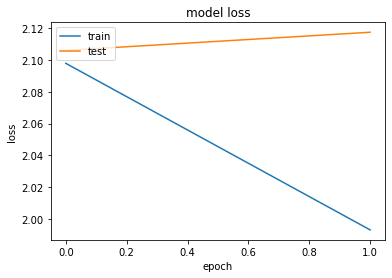

156/156 [==============================] - 6s 37ms/step - loss: 2.1060 - accuracy: 0.3007 - sparse_top_k_categorical_accuracy: 0.5970
Result on validation data:  {'loss': 2.10602068901062, 'accuracy': 0.30068108439445496, 'sparse_top_k_categorical_accuracy': 0.5969551205635071}
312/312 [==============================] - 12s 38ms/step - loss: 2.1198 - accuracy: 0.2915 - sparse_top_k_categorical_accuracy: 0.5872
Result on test data:  {'loss': 2.119795083999634, 'accuracy': 0.2914663553237915, 'sparse_top_k_categorical_accuracy': 0.5872395634651184}


In [ ]:
train_model(model, 25)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23561152  
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 15)                7695      
Total params: 24,617,935
Trainable params: 1,056,783
Non-trainable params: 23,561,152
_________________________________________________________________
Epoch 1/25
   2/1093 [..............................] - ETA: 54s - loss: 3.1341 - accuracy: 0.0938 - sparse_top_k_categorical_accuracy: 0.2031WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0236s vs `on_train_batch_end` time: 0.0747s). Check your callbacks.


1093/1093 [==============================] - ETA: 0s - loss: 2.2020 - accuracy: 0.2742 - sparse_top_k_categorical_accuracy: 0.5579WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0143s vs `on_test_batch_end` time: 0.0820s). Check your callbacks.



Epoch 00001: val_loss improved from inf to 2.09856, saving model to temp_weights.h5
1093/1093 [==============================] - 126s 115ms/step - loss: 2.2020 - accuracy: 0.2742 - sparse_top_k_categorical_accuracy: 0.5579 - val_loss: 2.0986 - val_accuracy: 0.2981 - val_sparse_top_k_categorical_accuracy: 0.5988
Epoch 2/25
1093/1093 [==============================] - ETA: 0s - loss: 2.0066 - accuracy: 0.3365 - sparse_top_k_categorical_accuracy: 0.6327
Epoch 00002: val_loss improved from 2.09856 to 2.07740, saving model to temp_weights.h5
1093/1093 [==============================] - 128s 117ms/step - loss: 2.0066 - accuracy: 0.3365 - sparse_top_k_categorical_accuracy: 0.6327 - val_loss: 2.0774 - val_accuracy: 0.3117 - val_sparse_top_k_categorical_accuracy: 0.6020
Epoch 3/25
1093/1093 [==============================] - ETA: 0s - loss: 1.8953 - accuracy: 0.3749 - sparse_top_k_categorical_accuracy: 0.6691
Epoch 00003: val_loss did not improve from 2.07740
1093/1093 [=======================

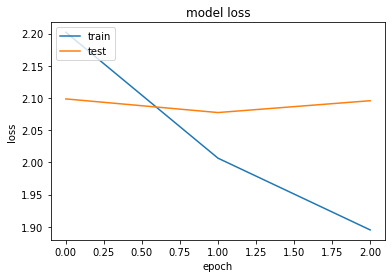

      2/Unknown - 0s 93ms/step - loss: 2.0964 - accuracy: 0.2969 - sparse_top_k_categorical_accuracy: 0.5312WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0200s vs `on_test_batch_end` time: 0.0845s). Check your callbacks.


156/156 [==============================] - 16s 103ms/step - loss: 2.0768 - accuracy: 0.3121 - sparse_top_k_categorical_accuracy: 0.6030
Result on validation data:  {'loss': 2.076798439025879, 'accuracy': 0.3120993673801422, 'sparse_top_k_categorical_accuracy': 0.6029647588729858}
      2/Unknown - 0s 93ms/step - loss: 2.4365 - accuracy: 0.2656 - sparse_top_k_categorical_accuracy: 0.5156WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0189s vs `on_test_batch_end` time: 0.0846s). Check your callbacks.


312/312 [==============================] - 32s 102ms/step - loss: 2.0878 - accuracy: 0.3047 - sparse_top_k_categorical_accuracy: 0.5985
Result on test data:  {'loss': 2.087773561477661, 'accuracy': 0.3046875, 'sparse_top_k_categorical_accuracy': 0.5984575152397156}


In [ ]:
model = create_model_hub("https://tfhub.dev/tensorflow/resnet_50/feature_vector/1", 0.0001)
model.summary()
train_model(model, 25)

Epoch 1/25
   2/1093 [..............................] - ETA: 28s - loss: 2.7797 - accuracy: 0.0625 - sparse_top_k_categorical_accuracy: 0.2031WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0194s vs `on_train_batch_end` time: 0.0330s). Check your callbacks.


1093/1093 [==============================] - ETA: 0s - loss: 2.2361 - accuracy: 0.2593 - sparse_top_k_categorical_accuracy: 0.5369WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0177s vs `on_test_batch_end` time: 0.0316s). Check your callbacks.



Epoch 00001: val_loss improved from inf to 2.15314, saving model to temp_weights.h5
1093/1093 [==============================] - 69s 63ms/step - loss: 2.2361 - accuracy: 0.2593 - sparse_top_k_categorical_accuracy: 0.5369 - val_loss: 2.1531 - val_accuracy: 0.2817 - val_sparse_top_k_categorical_accuracy: 0.5681
Epoch 2/25
1093/1093 [==============================] - ETA: 0s - loss: 2.1168 - accuracy: 0.2969 - sparse_top_k_categorical_accuracy: 0.5875
Epoch 00002: val_loss improved from 2.15314 to 2.12511, saving model to temp_weights.h5
1093/1093 [==============================] - 68s 62ms/step - loss: 2.1168 - accuracy: 0.2969 - sparse_top_k_categorical_accuracy: 0.5875 - val_loss: 2.1251 - val_accuracy: 0.2973 - val_sparse_top_k_categorical_accuracy: 0.5931
Epoch 3/25
1093/1093 [==============================] - ETA: 0s - loss: 2.0593 - accuracy: 0.3153 - sparse_top_k_categorical_accuracy: 0.6094
Epoch 00003: val_loss did not improve from 2.12511
1093/1093 [===========================

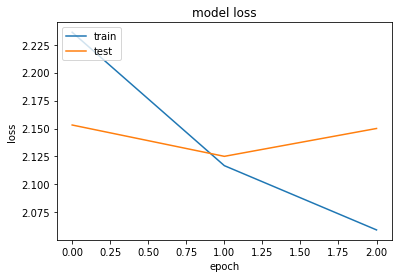

      2/Unknown - 0s 41ms/step - loss: 2.0636 - accuracy: 0.3438 - sparse_top_k_categorical_accuracy: 0.6875WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0174s vs `on_test_batch_end` time: 0.0365s). Check your callbacks.


156/156 [==============================] - 8s 54ms/step - loss: 2.1261 - accuracy: 0.2969 - sparse_top_k_categorical_accuracy: 0.5929
Result on validation data:  {'loss': 2.1260859966278076, 'accuracy': 0.296875, 'sparse_top_k_categorical_accuracy': 0.5929487347602844}
      2/Unknown - 0s 41ms/step - loss: 2.3076 - accuracy: 0.2656 - sparse_top_k_categorical_accuracy: 0.5000WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0214s vs `on_test_batch_end` time: 0.0347s). Check your callbacks.


312/312 [==============================] - 17s 54ms/step - loss: 2.1250 - accuracy: 0.2869 - sparse_top_k_categorical_accuracy: 0.5788
Result on test data:  {'loss': 2.1249961853027344, 'accuracy': 0.2868589758872986, 'sparse_top_k_categorical_accuracy': 0.5788261294364929}


In [ ]:
model = create_model_hub("https://tfhub.dev/google/imagenet/inception_v2/feature_vector/4", 0.0001)
train_model(model, 25)

In [ ]:
model=create_model_hub("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",0.0001)

Epoch 1/25
   1/1093 [..............................] - ETA: 0s - loss: 2.9409 - accuracy: 0.0312 - sparse_top_k_categorical_accuracy: 0.0938WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0158s vs `on_train_batch_end` time: 0.0244s). Check your callbacks.


1093/1093 [==============================] - ETA: 0s - loss: 2.2307 - accuracy: 0.2640 - sparse_top_k_categorical_accuracy: 0.5388
Epoch 00001: val_loss improved from inf to 2.14655, saving model to temp_weights.h5
1093/1093 [==============================] - 55s 51ms/step - loss: 2.2307 - accuracy: 0.2640 - sparse_top_k_categorical_accuracy: 0.5388 - val_loss: 2.1465 - val_accuracy: 0.2923 - val_sparse_top_k_categorical_accuracy: 0.5805
Epoch 2/25
1092/1093 [============================>.] - ETA: 0s - loss: 2.0334 - accuracy: 0.3267 - sparse_top_k_categorical_accuracy: 0.6193
Epoch 00002: val_loss improved from 2.14655 to 2.12179, saving model to temp_weights.h5
1093/1093 [==============================] - 55s 51ms/step - loss: 2.0337 - accuracy: 0.3265 - sparse_top_k_categorical_accuracy: 0.6192 - val_loss: 2.1218 - val_accuracy: 0.3031 - val_sparse_top_k_categorical_accuracy: 0.5901
Epoch 3/25
1093/1093 [==============================] - ETA: 0s - loss: 1.9021 - accuracy: 0.3732 - s

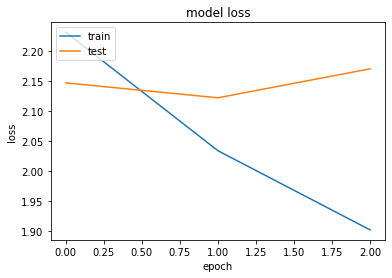

156/156 [==============================] - 7s 43ms/step - loss: 2.1228 - accuracy: 0.3029 - sparse_top_k_categorical_accuracy: 0.5897
Result on validation data:  {'loss': 2.1227946281433105, 'accuracy': 0.30288460850715637, 'sparse_top_k_categorical_accuracy': 0.5897436141967773}
312/312 [==============================] - 13s 43ms/step - loss: 2.1499 - accuracy: 0.2865 - sparse_top_k_categorical_accuracy: 0.5707
Result on test data:  {'loss': 2.149858236312866, 'accuracy': 0.2864583432674408, 'sparse_top_k_categorical_accuracy': 0.5707131624221802}


In [ ]:
train_model(model,25)

In [ ]:
model=create_model_hub("https://tfhub.dev/google/imagenet/inception_v1/classification/4",0.0001)

Epoch 1/25
   1/1093 [..............................] - ETA: 0s - loss: 3.3263 - accuracy: 0.0938 - sparse_top_k_categorical_accuracy: 0.2500WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0144s vs `on_train_batch_end` time: 0.0257s). Check your callbacks.


1092/1093 [============================>.] - ETA: 0s - loss: 2.2582 - accuracy: 0.2618 - sparse_top_k_categorical_accuracy: 0.5376
Epoch 00001: val_loss improved from inf to 2.16592, saving model to temp_weights.h5
1093/1093 [==============================] - 56s 51ms/step - loss: 2.2580 - accuracy: 0.2617 - sparse_top_k_categorical_accuracy: 0.5377 - val_loss: 2.1659 - val_accuracy: 0.2881 - val_sparse_top_k_categorical_accuracy: 0.5777
Epoch 2/25
1093/1093 [==============================] - ETA: 0s - loss: 2.0314 - accuracy: 0.3252 - sparse_top_k_categorical_accuracy: 0.6210
Epoch 00002: val_loss did not improve from 2.16592
1093/1093 [==============================] - 56s 51ms/step - loss: 2.0314 - accuracy: 0.3252 - sparse_top_k_categorical_accuracy: 0.6210 - val_loss: 2.1680 - val_accuracy: 0.2909 - val_sparse_top_k_categorical_accuracy: 0.5827
Epoch 3/25
1092/1093 [============================>.] - ETA: 0s - loss: 1.8997 - accuracy: 0.3726 - sparse_top_k_categorical_accuracy: 0.6

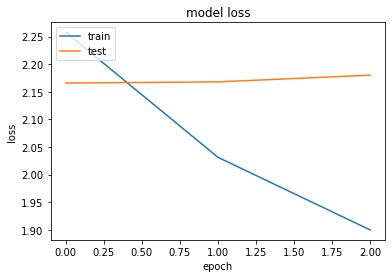

156/156 [==============================] - 7s 44ms/step - loss: 2.1676 - accuracy: 0.2877 - sparse_top_k_categorical_accuracy: 0.5771
Result on validation data:  {'loss': 2.167635202407837, 'accuracy': 0.28766027092933655, 'sparse_top_k_categorical_accuracy': 0.5771234035491943}
      1/Unknown - 0s 19ms/step - loss: 2.0657 - accuracy: 0.2500 - sparse_top_k_categorical_accuracy: 0.5938WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0156s vs `on_test_batch_end` time: 0.0238s). Check your callbacks.


312/312 [==============================] - 14s 44ms/step - loss: 2.1725 - accuracy: 0.2827 - sparse_top_k_categorical_accuracy: 0.5645
Result on test data:  {'loss': 2.1725096702575684, 'accuracy': 0.28265222907066345, 'sparse_top_k_categorical_accuracy': 0.5645031929016113}


In [ ]:
train_model(model,25)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [ ]:
tedf = pd.read_csv(csv_path, header = 0, index_col = 0, encoding='latin1')
cat_tup = tedf.groupby(["cat_id", "Genre"]).count().index.values
cat_dict=dict() 
for cat_id,cat in cat_tup: 
    cat_dict[cat_id] = cat
print(cat_dict)

{0: 'Adventure', 1: 'Arcade', 2: 'Fighting', 3: 'Indie', 4: 'Music', 5: 'Pinball', 6: 'Platform', 7: 'Puzzle', 8: 'Quiz/Trivia', 9: 'Racing', 10: 'Role-playing(RPG)', 11: 'Shooter', 12: 'Simulator', 13: 'Sport', 14: 'Strategy'}


In [ ]:
_,_,df = load_csv() # load train data 
#df = tedf
print("...df loaded")
BATCH_SIZE = 32
results = []
newdata = []

# seperate data based on category
for i in range(outdim_size):
  newdata.append(df[df.cat_id==i])

# write tfrecord file and load dataset outdim_siz number of dataset
dataset = load_cat(newdata, keras_hub=True)
print("...dataset loaded")

...df loaded
...dataset loaded


In [ ]:
def load_cat(newdata, tfrecord_path = "new.tfrecord", keras_hub=False):
    data = load_csv()
    
    dataset = []
    for i in range(outdim_size):
        tfrecord_path = "test_cat"+str(i)+".tfrecord"
        write_tfrecord(newdata[i], tfrecord_path)
        dataset.append(get_dataset(tfrecord_path))

    return dataset


In [ ]:
cat_sample_size = df.groupby(["Genre", "cat_id"]).count().Descriptions

from collections import Counter

# each iteration the below code will count the predic and apend in the prediction list
pred_count = []
# list of dataframe that contains the prediction layer for each category
prob_df_list = []
for i in range(outdim_size):
  steps = cat_sample_size[i] // 32
  prob_y = model.predict(dataset[i].repeat(), steps=steps)
  pred_y = tf.argmax(prob_y, 1)
  pred_count.append(Counter(pred_y.numpy()))

  feat_cols = ['f'+str(k) for k in range(prob_y.shape[1])]
  prob_df = pd.DataFrame(prob_y,columns=feat_cols)
  prob_df["genre"] = [cat_dict[i] for k in range(prob_y.shape[0])]
  prob_df_list.append(prob_df)

# put all the predict into confusion matrix where row is truth value
conf_mat = pd.DataFrame(pred_count, columns=range(outdim_size))
conf_mat.fillna(0, inplace=True)

# prediction layer with true category
prob_df = pd.concat(prob_df_list, ignore_index=True, sort=False)

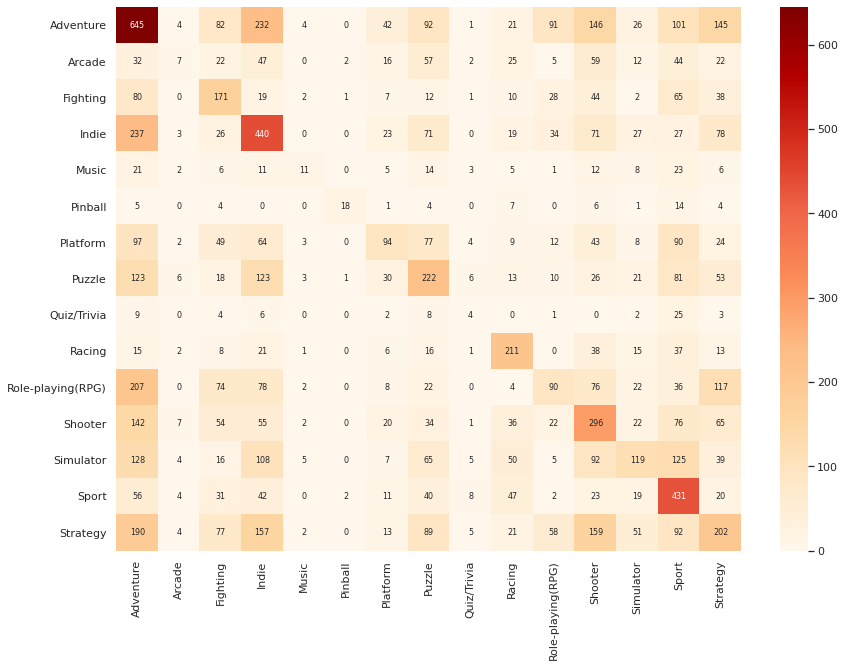

In [ ]:
df_cm = pd.DataFrame(conf_mat.values.astype(int), cat_dict.values(), cat_dict.values())
plt.figure(figsize=(14,10))
sns.set(font_scale=1) # for label size
sns.heatmap(df_cm, annot=True,fmt='d', annot_kws={"size": 8}, cmap="OrRd") # font size

plt.savefig("filename.png")
plt.show()

In [ ]:
print('ResNet50 accuracy by genre:')
for i in range(outdim_size):
  acc = conf_mat.values[i,i]/sum(conf_mat.loc[i,:])
  print(cat_dict[i]," (",str(i), "): ",  str(acc*100), " %")


ResNet50 accuracy by genre:
Adventure  ( 0 ):  39.52205882352941  %
Arcade  ( 1 ):  1.9886363636363635  %
Fighting  ( 2 ):  35.625  %
Indie  ( 3 ):  41.66666666666667  %
Music  ( 4 ):  8.59375  %
Pinball  ( 5 ):  28.125  %
Platform  ( 6 ):  16.319444444444446  %
Puzzle  ( 7 ):  30.16304347826087  %
Quiz/Trivia  ( 8 ):  6.25  %
Racing  ( 9 ):  54.947916666666664  %
Role-playing(RPG)  ( 10 ):  12.228260869565217  %
Shooter  ( 11 ):  35.57692307692308  %
Simulator  ( 12 ):  15.494791666666666  %
Sport  ( 13 ):  58.559782608695656  %
Strategy  ( 14 ):  18.035714285714285  %
